
    Gff Parsing script to transform E. coli GFF to a python dictionary
    Copyright (C) 2019  Fuad Mohammad, fuadm424@gmail.com


    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.
    


In [1]:


### Settings and Inputs
# to exclude steps, change "y" to "n"
import ribo_util
import ribo_main
import ribo_analysis
import ribo_plot

import pandas as pd
import numpy as np
from math import log
from sklearn.linear_model import LinearRegression
import itertools

import plotly 
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import plot
import cPickle as pickle

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from RNAstructure import RNAstructure

from datetime import datetime
from multiprocessing import Process, Pool
import os, time
import subprocess
import struct
import cPickle as pickle
import csv
from BCBio import GFF
from Bio import Seq
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import itertools

import pandas as pd
import numpy as np
from IPython.display import display

library_creator = 'FM'        #FM, KS, CW, Menkin, Li, etc...
organism        = 'Coli'      #Coli, Subtilis, Tuberculosis etc...


### Input directories 
path_pc     = '/Volumes/HDD/Ribo_seq/'
inpath      = path_pc + 'libraries/'
path_script = '/Users/fuad/Dropbox/'
paths_in = {
    'path_gff'         : path_pc + 'annotations/'+organism+'/'+organism+'.gff',
    'path_gff_analysis': path_pc + 'annotations/'+organism+'/analysis/', 
    'path_badgenes'    : path_pc + 'annotations/'+organism+'/bad_genes.csv',
    'path_annotation'  : path_pc + 'annotations/'+organism+'/annotation.csv',
    'SD_affinity'      : path_pc + 'annotations/'+organism+'/___________.csv',
    'path_gff_dict'    : path_pc + 'annotations/'+organism+'/'+organism+'_dict',   #will be made from GFF
    'SD_affinity'      : path_script + 'scripts/SD_CACCUCCU/sequences_octamers.csv',
    }


### Output directories
paths_out = {
    'path_log'       : inpath  + 'density/logs/',
    'path_analysis'  : inpath  + 'analysis/individual/',
    'path_figures'   : inpath  + 'figures/',
    }


In [2]:


def shine_dalgarno_affinity(aSD_seq, SD_seq):
    
    '''Calculate diplex energy (Kcal/mol) using RNAstructure:
    Dave Mathews Lab (http://rna.urmc.rochester.edu/RNAstructure.html)'''

    aSD_seq = str(aSD_seq)
    SD_seq  = str(SD_seq)
    
    RNA_prog = RNAstructure(exe_path="/Users/fuad/anaconda/bin/RNAstructure/exe/")
    energy = RNA_prog.DuplexFold(aSD_seq,SD_seq)
    
    return energy


def GC_of_CDS(CDS_seq):
    
    '''Calculate nucleotide composition of each alias in GFF'''
    CDS_length = len(CDS_seq)
    
    G = 0 
    C = 0 
    A = 0 
    T = 0
    
    for nucleotide in CDS_seq:
        if nucleotide == 'G':
            G += 1
        elif nucleotide == 'C':
            C += 1
        elif nucleotide == 'A':
            A += 1
        elif nucleotide == 'T':
            T += 1
    
    G = float(G) / CDS_length * 100
    C = float(C) / CDS_length * 100
    A = float(A) / CDS_length * 100
    T = float(T) / CDS_length * 100
    
    return G, C, A, T

#def uorf_finder

    '''Find uORFs upstream of annotated genes
        - start from annotated start codons
            find upstream AUG within 100 nt from start in any frame
            find in frame stop and length 
            find SD strength          
    
    '''


def GFF_to_dict(paths_in, gff_settings):
    
    '''Parse gff into dict:
        - feat_of_interest = what to look for in gff (protein_coding, tRNA, rRNA, etc)
        - name_qual        = qualifier for alias/gene name (Name, gene_id)
        - name_qual_alt    = alternative qualifier, if none, set as 'none' 
        - biotype_qual     = qualifier for type of feature (biotype, etc)
        
        These values must correspont to values in the GFF'''
    
    '''Unload gff_settings'''
    
    path_out         = gff_settings['path_out']
    feat_of_interest = gff_settings['feat_of_interest']  #all, protein_coding, tRNA, rRNA
    name_qual        = gff_settings['name_qual']
    name_qual_alt    = gff_settings['name_qual_alt']
    remove_genes     = gff_settings['remove_genes']
    aSD_seq          = gff_settings['aSD_seq']
    path_badgenes    = paths_in['path_badgenes']
    path_annotation  = paths_in['path_annotation']
    
    '''Output path can be defined, or use 0 to set as the annotation file for my main pipeline'''
    
    if path_out == 0:
        path_gff_dict = paths_in['path_gff_dict']
    else:
        path_gff_dict = path_out
    
    '''Parse GFF using BCBio'''
    
    GFFgen = GFF.parse(paths_in['path_gff'])
    chr = GFFgen.next()
    feat_num = 0
    
    '''Define genetic code'''
    
    aa_code, codon_code = ribo_util.get_genetic_code()
    aa_comp_dict = {}
    
    '''Define data arrays: will be used as columns for pandas DateFrame'''

    gff_dict   = {}
    aliaslist  = []
    startlist  = []
    stoplist   = []
    seqlist    = []
    typelist   = []
    strandlist = []
    startcodon = []
    stopcodon  = []
    SDaffinity = []
    IEpoint    = []
    annolist   = []
    G_content  = []
    C_content  = []
    A_content  = []
    T_content  = []
    
    aa_start = {}
    aa_stop  = {}
    
    for aa in aa_code.keys():
        aa_start[aa] = [0] * 25
        aa_stop[aa]  = [0] * 25
    
    '''Make list of bad genes'''
            

    # from Gene-Wei-Li 

    bad_genes = pd.read_csv(path_badgenes)
    bad_genes = bad_genes.to_dict(orient='list')
    bad_genes = bad_genes['GeneName']
    
    # get gene functions from csv: made by hand
    
    annotations = pd.read_csv(path_annotation)
    annotations = annotations.to_dict(orient='list')
        

    '''Sift through GFF for relevant information'''
    
    for feature in chr.features:
        
        if feature.sub_features == []:
                feat_num+=1
                continue
                
        if remove_genes == 'yes':
            
            '''Skip over non-CDS annotations'''
            
            if not feature.sub_features[0].type == feat_of_interest:
                feat_num+=1
                continue        
            elif feature.qualifiers.has_key('pseudo') == True:
                feat_num+=1
                continue
            else:
                feature_type = 'CDS'
        else: 
            
            '''Add feat type to GFF, noting pseudogenes'''
            
            if feature.qualifiers.has_key('pseudo') == True:
                feature_type = 'pseudo'
            else: 
                feature_type = feature.sub_features[0].type 
                
                    
        '''Get feature name'''
        
        if name_qual in feature.qualifiers:
            feat_name = feature.qualifiers[name_qual][0]
        elif name_qual_alt in feature.qualifiers:
            feat_name = feature.qualifiers[name_qual_alt][0]
        else:
            feat_name = 'None'
            feat_num+=1
            continue
        
        alias = feat_name
        
        '''get annotation from custom list'''
        if alias in annotations['alias']:
            index = annotations['alias'].index(alias)
            annotation = annotations['annotation'][index]   
        else: 
            annotation = 'None'
        
        '''Remove feature if bad'''
        
        if remove_genes == 'yes':
            if annotation == 'ignore':
                feat_num+=1
                continue
        
        '''Get start, end, and strand position'''
        
        start  = feature.location.start.position 
        end    = feature.location.end.position
        strand = feature.strand                   
            
        '''Each strand is treated differently, + strand == 1'''
            
        if strand == 1:
                
            '''I save gene sequence + 50 bp from each end:
            makes it easier to analyze start and stop sequence 
            context without using whole genome sequence'''

            if start < 50:      # if gene is near the beginning of genome sequence:
                sequence = 'N' * (50 - start)                  # TB GFF starts at 0, add N * 50
                sequence = sequence + chr[0:end+50].seq        # gene sequence + 50nt at each end
            else: 
                sequence = chr[start-50:end+50].seq            # gene sequence + 50nt at each end

            strand_val = '+'
            startcodon_pos = start
            stopcodon_pos  = end-1

            if start > 200: 
                upstream_seq = chr[start-200:start+100].seq

        else:

            '''For minus strand, 'end' is start codon, 'start' is stop codon
            and sequence is reverse compliment of gene sequence.'''

            sequence_rc = chr[start-50:end+50].seq
            sequence = sequence_rc.reverse_complement()

            strand_val = '-'
            startcodon_pos = end-1
            stopcodon_pos  = start

            if end + 200 > len(chr.seq):
                upstream_seq = 'none'
            else:
                upstream_seq_rc = chr[end-100:end+200].seq
                upstream_seq = upstream_seq_rc.reverse_complement()
            
        sequence = str(sequence)
        start_codon = sequence[50:53:1]
        stop_codon  = sequence[-53:-50]
        
        '''print an alias and sequence of interest'''
        
        if alias == 'alaS':
            print alias, sequence
        if alias == 'leuS':
            print alias, sequence
        if alias == 'glyS':
            print alias, sequence
        if alias == 'pheS':
            print alias, sequence

        '''get sequence from start to stop for GC analysis'''

        CDS_seq = sequence[50:-50:1]
        CDS_seq_length = len(CDS_seq)

        G, C, A, T = GC_of_CDS(CDS_seq)
        
        '''get codon composition metaplot data'''
                
        if CDS_seq_length % 3 == 0: 
            codons_seq = [CDS_seq[i:i+3] for i in range(0, CDS_seq_length, 3)]
            aa_seq     = [codon_code[codon] for codon in codons_seq] 
        else: 
            aa_seq = []

        #get start and stop codon alignment
        
        if len(aa_seq) > 50:
            
            position_index = range(0, 25)
            for position in position_index:

                # start position data
                aa = aa_seq[position]
                aa_start[aa][position] += 1

                # stop position data
                aa = aa_seq[-25 + position]
                aa_stop[aa][position] += 1  

        '''Calculate SD affinity'''

        SD_seq = sequence[30:50:1]    # analyze 20 nt upstream of start codons
        SD_affinity = shine_dalgarno_affinity(aSD_seq, SD_seq)

        '''Calculate Isoelectric point of protein'''
        
        analysed_seq = ProteinAnalysis(CDS_seq)
        pI           = analysed_seq.isoelectric_point()
        
        '''Append data to lists'''
        
        annolist.append(annotation)
        typelist.append(feature_type)
        aliaslist.append(alias)
        seqlist.append(sequence)
        strandlist.append(strand_val)
        startlist.append(startcodon_pos)
        stoplist.append(stopcodon_pos)
        startcodon.append(start_codon)
        stopcodon.append(stop_codon)
        SDaffinity.append(SD_affinity)
        IEpoint.append(pI)
        G_content.append(G)
        C_content.append(C)
        A_content.append(A)
        T_content.append(T)

        feat_num+=1

    '''Normalize codon composition data'''
    
    for aa in aa_start.keys():
        total_aa_start = sum(aa_start[aa])
        avg_aa_start   = float(total_aa_start / 25)
        if avg_aa_start == 0:
            avg_aa_start = 1
        aa_start[aa]   = [ float(i / avg_aa_start) for i in aa_start[aa]]
        
        total_aa_stop = sum(aa_stop[aa])
        avg_aa_stop   = float(total_aa_stop / 25)
        if avg_aa_stop == 0:
            avg_aa_stop = 1
        aa_stop[aa]   = [ float(i / avg_aa_stop) for i in aa_stop[aa]]
    
    # reorder data for plotting
    data_df = {}
    position_list    = []
    aa_list          = []
    value_list_start = []
    value_list_stop  = []
    aa_property      = []
    
    
    
    for position in range(0, 25):
        for aa in aa_start.keys():
            
            if aa in ['R', 'H', 'K']:
                aa_prop = 'positive'
            if aa in ['D', 'E']:
                aa_prop = 'negative'
            if aa in ['S', 'T', 'N', 'Q']:
                aa_prop = 'polar'
            if aa in ['A', 'V', 'I', 'L', 'M', 'C']:
                aa_prop = 'hydrophobic'
            if aa in ['G', 'P']:
                aa_prop = 'steric'
            if aa in ['F', 'Y', 'W']:
                aa_prop = 'bulky'
            if aa in ['_']:
                continue
            
            value_start = aa_start[aa][position]
            value_stop  = aa_stop[aa][position]
            value_list_start.append(value_start)
            value_list_stop.append(value_stop)
            position_list.append(position)
            aa_list.append(aa)
            aa_property.append(aa_prop)
            
    data_df['Start']      = value_list_start
    data_df['Stop']       = value_list_stop
    data_df['Amino_Acid'] = aa_list
    data_df['Position']   = position_list
    data_df['Property']   = aa_property
    
    data_df = pd.DataFrame(data_df)
    
    display(data_df)
    
    sns.set(style="white")    
    plt.figure(figsize=(25,6))
    plt.subplot(1,2,1)
    plot1 = sns.lineplot(x="Position", y="Start", hue="Amino_Acid", data=data_df)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.subplot(1,2,2)
    plot2 = sns.lineplot(x="Position", y="Stop", hue="Amino_Acid", data=data_df)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    
    '''Append lists to gff_dict'''

    gff_dict['Alias']    = aliaslist
    gff_dict['Strand']   = strandlist
    gff_dict['Start']    = startlist
    gff_dict['Stop']     = stoplist
    gff_dict['Sequence'] = seqlist
    gff_dict['Start_Codon'] = startcodon
    gff_dict['Stop_Codon']  = stopcodon
    gff_dict['Type']        = typelist
    gff_dict['Annotation']  = annolist
    gff_dict['SD_affinity'] = SDaffinity
    gff_dict['pI']        = SDaffinity
    gff_dict['G_content'] = G_content
    gff_dict['C_content'] = C_content
    gff_dict['A_content'] = A_content
    gff_dict['T_content'] = T_content

           
    '''Pickle dict for use later'''
    ribo_util.makePickle(gff_dict,path_gff_dict)
    
    '''print dataframe, and save as .csv for use later'''
    ## Print GFF to check 
    gff_df = pd.DataFrame(gff_dict)
    display(gff_df)
    gff_df.to_csv(path_gff_dict + '.csv')
    
    return data_df

def SD_affinity_genome(paths_in):
    
    '''This function takes octamers of genomic sequence and calculates shine dalgarno affinity:
    output is a size separated dict that can be used like a density dict.'''
    # load octamers
    SD_affinity = paths_in['SD_affinity']
    
    affinity_list = pd.read_csv(SD_affinity)
    affinity_list = pd.Series(affinity_list.SD_affinity.values,index=affinity_list.Octamer).to_dict()
        
    length_range     = range(10, 46) 
    GFFgen = GFF.parse(paths_in['path_gff'])
    chr = GFFgen.next()
    feat_num = 0
    
    affinity_plus = []
    affinity_minus = []
    density_plus_sizesep = {}
    density_minus_sizesep = {}
    
    sequence    = chr.seq
    sequence_rc = sequence.reverse_complement()
    genome_size = len(sequence)
    
    position = 0
    for position in range (0, genome_size):
        if position < 8:
            motif    = 'AAAAAAAA'
            motif_rc = 'AAAAAAAA'
        elif genome_size - position < 8:
            motif_rc = 'AAAAAAAA'
            motif    = 'AAAAAAAA'
        else:
            
            motif    = sequence[position - 8: position].transcribe()
            motif_rc = sequence[position: position + 8].transcribe()
        
            motif_rc = motif_rc.reverse_complement()
        
        if len(motif) == 8 and len(motif_rc) == 8:
            SD_affinity_plus  = affinity_list[motif]  
            SD_affinity_minus = affinity_list[motif_rc]
        else:
            SD_affinity_plus  = 0.0  
            SD_affinity_minus = 0.0
        
        if position == 100000:
            print '100000'
        if position == 500000:
            print '500000'
        if position == 1000000:
            print '1000000'
        if position == 2000000:
            print '2000000'
        
        affinity_plus.append(SD_affinity_plus)
        affinity_minus.append(SD_affinity_minus)
    
    for length in length_range:
        density_plus_sizesep[length]  = affinity_plus
        density_minus_sizesep[length] = affinity_minus
        
    path_den   = inpath  + 'density/density/SD1/'
    ribo_util.makePickle(density_plus_sizesep,path_den+"plus_sizesep")
    ribo_util.makePickle(density_minus_sizesep,path_den+"minus_sizesep")

    return 


leuS ACCTCAACGCTACATTTGTAGCCGTATTGAAAACAGGACCACTGGCTGCCATGCAAGAGCAATACCGCCCGGAAGAGATAGAATCCAAAGTACAGCTTCATTGGGATGAGAAGCGCACATTTGAAGTAACCGAAGACGAGAGCAAAGAGAAGTATTACTGCCTGTCTATGCTTCCCTATCCTTCTGGTCGACTACACATGGGCCACGTACGTAACTACACCATCGGTGACGTGATCGCCCGCTACCAGCGTATGCTGGGCAAAAACGTCCTGCAGCCGATCGGCTGGGACGCGTTTGGTCTGCCTGCGGAAGGCGCGGCGGTGAAAAACAACACCGCTCCGGCACCGTGGACGTACGACAACATCGCGTATATGAAAAACCAGCTCAAAATGCTGGGCTTTGGTTATGACTGGAGCCGCGAGCTGGCAACCTGTACGCCGGAATACTACCGTTGGGAACAGAAATTCTTCACCGAGCTGTATAAAAAAGGCCTGGTATATAAGAAGACTTCTGCGGTCAACTGGTGCCCGAACGACCAGACCGTACTGGCGAACGAACAAGTTATCGACGGCTGCTGCTGGCGCTGCGATACCAAAGTTGAACGTAAAGAGATCCCGCAGTGGTTTATCAAAATCACTGCTTACGCTGACGAGCTGCTCAACGATCTGGATAAACTGGATCACTGGCCAGACACCGTTAAAACCATGCAGCGTAACTGGATCGGTCGTTCCGAAGGCGTGGAGATCACCTTCAACGTTAACGACTATGACAACACGCTGACCGTTTACACTACCCGCCCGGACACCTTTATGGGTTGTACCTACCTGGCGGTAGCTGCGGGTCATCCGCTGGCGCAGAAAGCGGCGGAAAATAATCCTGAACTGGCGGCCTTTATTGACGAATGCCGTAACACCAAAGTTGCCGAAGCTGAAATGGCGACGATGGAGAAAAAAGGCGTCGATACTGGCTTTAAAGCGGTTCACCCATTAACGGGC

,Amino_Acid,Position,Property,Start,Stop
0,A,0,hydrophobic,0.000000,0.985955
1,C,0,hydrophobic,0.000000,1.250000
2,E,0,negative,0.000000,0.988462
3,D,0,negative,0.000000,1.233161
4,G,0,steric,0.000000,1.191837
5,F,0,bulky,0.000000,0.948905
6,I,0,hydrophobic,0.007491,1.125581
7,H,0,positive,0.000000,1.100000
8,K,0,positive,0.000000,0.823009
9,M,0,hydrophobic,16.097778,1.206897


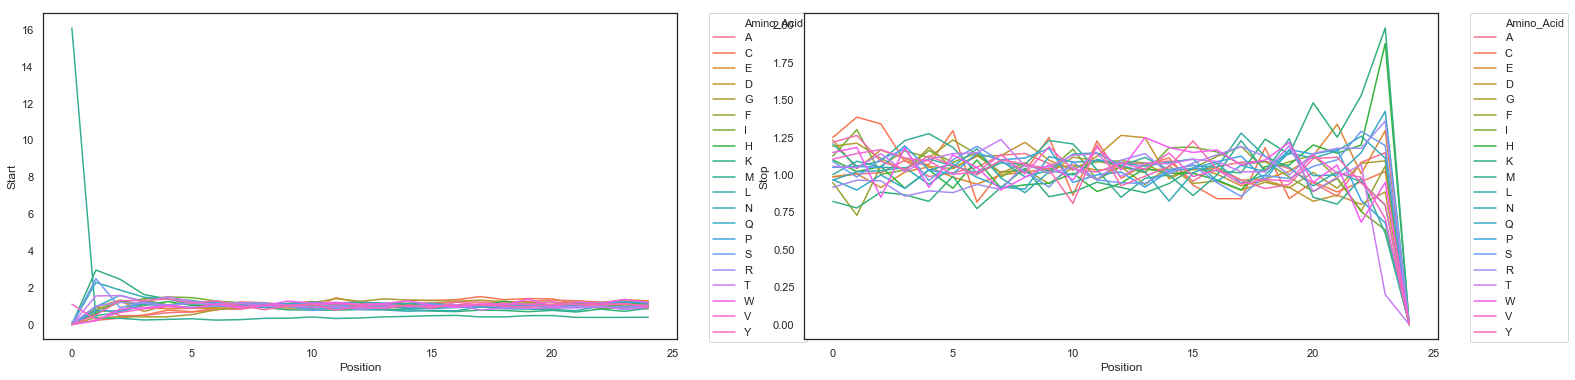

,A_content,Alias,Annotation,C_content,G_content,SD_affinity,Sequence,Start,Start_Codon,Stop,Stop_Codon,Strand,T_content,Type,pI
0,31.818182,thrL,None,33.333333,18.181818,-2.4,ATATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAAC...,189,ATG,254,TGA,+,16.666667,CDS,-2.4
1,22.452294,thrA,None,24.969549,28.095818,-5.5,CCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGAGGTAAC...,336,ATG,2798,TGA,+,24.482339,CDS,-5.5
2,20.900322,thrB,None,24.758842,31.511254,-4.9,TGTCTTTGCTGATCTGCTACGTACCCTCTCATGGAAGTTAGGAGTC...,2800,ATG,3732,TAA,+,22.829582,CDS,-4.9
3,23.698524,thrC,None,24.553225,28.282828,-3.1,TTCATATTTGCCGGCTGGATACGGCGGGCGCACGAGTACTGGAAAA...,3733,ATG,5019,TAA,+,23.465423,CDS,-3.1
4,25.925926,yaaX,None,27.946128,25.925926,-4.9,GTAATCTCCGGATATCGACCCATAACGGGCAATGATAAAAGGAGTA...,5233,GTG,5529,TAA,+,20.202020,CDS,-4.9
5,26.254826,yaaA,None,24.324324,25.353925,-4.3,CATTCTCATTTTTTGCTAAAGTCGGCATAAATTTCCTGCAAGGACT...,6458,ATG,5682,TAA,-,24.066924,CDS,-4.3
6,18.099231,yaaJ,None,25.786164,27.533194,-6.5,GTAACGTTTACACAGGAAAGTCATCGCGACCGGCAATAAGAGGGAT...,7958,ATG,6528,TAA,-,28.581412,CDS,-6.5
7,26.415094,talB,None,25.262055,26.729560,-2.9,GGCAGACCGGTTACATCCCCCTAACAAGCTGTTTAAAGAGAAATAC...,8237,ATG,9190,TAA,+,21.593291,CDS,-2.9
8,23.299320,mog,None,24.659864,29.761905,-3.3,TCGCAGTGTATCATTCTGTTTAACGAGACTGTTTAAACGGAAAAAT...,9305,ATG,9892,TAA,+,22.278912,CDS,-3.3
9,18.165785,yaaH,None,25.925926,27.160494,-7.2,ATTCAGGGAAATTATTTCACCATTCATTCGATGATGATTTTTGAGG...,10493,ATG,9927,TAA,-,28.747795,CDS,-7.2


In [3]:
gff_settings = {
    'path_out'         : 0,
    'feat_of_interest' : 'CDS',         #all, CDS, tRNA, rRNA
    'name_qual'        : 'Name',
    'name_qual_alt'    : 'gene_id',
    'remove_genes'     : 'yes',         #remove hard to align genes, if no, will add annotation 
    'aSD_seq'          : 'TCCTCC'
    }


data_df = GFF_to_dict(paths_in, gff_settings)

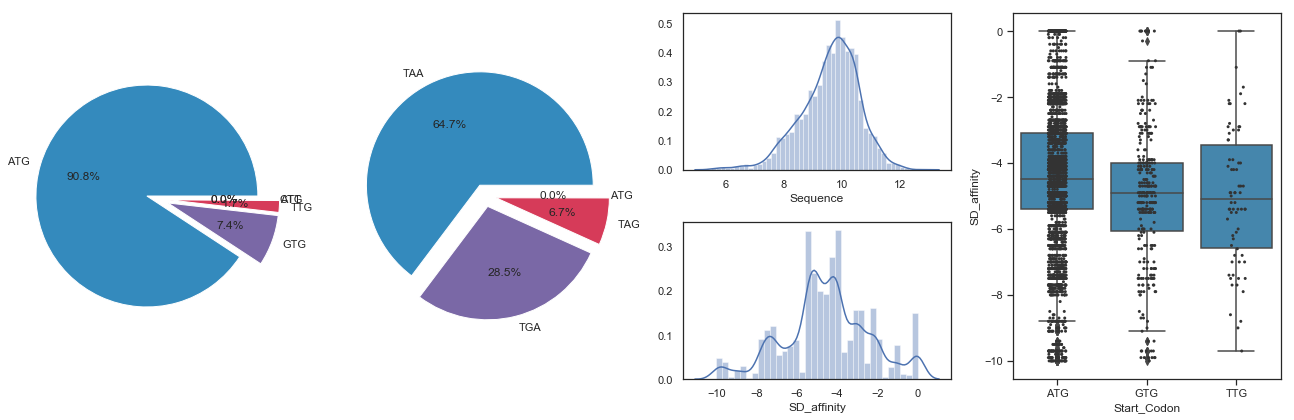

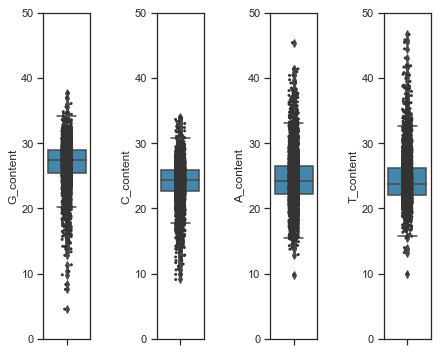

In [4]:
def plot_start(paths_in):
    
    '''Load data'''
    
    path_gff_dict = paths_in['path_gff_dict']
    gff_dict = ribo_util.unPickle(path_gff_dict)
    df = pd.DataFrame(gff_dict)     # load into pandas dataframe
    
    '''define data columns'''
    
    startcodons = df.Start_Codon          # set startcodon data
    stopcodons  = df.Stop_Codon           # set stopcodon data
    SDaffinity  = df.SD_affinity          # set SD affinity data
    sequence  = df.Sequence               # set sequence data
    seqlenght = sequence.str.len() - 100  # set sequence length data
    
    G_content = df.G_content
    C_content = df.C_content
    A_content = df.A_content
    T_content = df.T_content
    
    startcodon_data  = startcodons.value_counts()
    startcodon_id    = startcodon_data.index.tolist() 
    num_startcodons  = len(startcodon_id)
    
    stopcodon_data  = stopcodons.value_counts()
    stopcodon_id    = stopcodon_data.index.tolist() 
    num_stopcodons  = len(stopcodon_id)
    
    

    '''Plot using seaborn'''
    
    sns.set(style="white")    
    plt.figure(figsize=(18,6))
    
    '''Pie Charts'''
    
    colors = ["#348ABD", "#7A68A6", "#D63B59", "#467821", "#CB5C3B", "#CF4457", "#E24A33"]
    
    plt.subplot(1,4,1)
    explode = (0.1, 0.1, 0.1)
    for x in range(0, num_startcodons - 3):
        explode = explode + (0,)
    plot1 = plt.pie(startcodon_data, colors=colors, labels=startcodon_id, explode = explode,
                    autopct='%1.1f%%')
    plt.axis('equal')
        
    plt.subplot(1,4,2)
    explode = (0.1, 0.1, 0.1)
    for x in range(0, num_stopcodons - 3):
        explode = explode + (0,)
    plot2 = plt.pie(stopcodon_data, colors=colors, labels=stopcodon_id, explode = explode,
                    autopct='%1.1f%%')
    plt.axis('equal')
    
    '''Length Distribution'''
    
    plt.subplot(2,4,3)
    seqlenght = np.log2(seqlenght)
    plot3 = sns.distplot(seqlenght)
    
    '''SD affinity distribution'''
    
    plt.subplot(2,4,7)
    plot4 = sns.distplot(SDaffinity)
    
    '''shine dalgarno affinity separated by start codon'''
    
    ATG = df.loc[startcodons == "ATG"]
    GTG = df.loc[startcodons == "GTG"]
    TTG = df.loc[startcodons == "TTG"]
    
    
    startcodons_of_interest = [ATG, GTG, TTG]
    startcodon_df = pd.concat(startcodons_of_interest)  # new dataframe with major start codons
    
    sns.set(style="ticks")
    plt.subplot(1,4,4)
        
    plot5   = sns.boxplot(x = 'Start_Codon', y = 'SD_affinity', data = startcodon_df,
                 color="#348ABD")
    plot5_1 = sns.stripplot(x = 'Start_Codon', y = 'SD_affinity', data = startcodon_df,
              jitter=True, size=3, color=".2", linewidth=0)
    
    '''Display and save plot'''
    
    path_gff_analysis =  paths_in['path_gff_analysis']
    path_save = path_gff_analysis + 'Anotated Genome features'
    plt.savefig(path_save, format = 'pdf')
    
    plt.tight_layout()  
    plt.show()
    
    
    '''Plot genome '''
    sns.set(style="ticks")
    plt.figure(figsize=(10,6))
    
    ORF_composition = [G_content, C_content, A_content, T_content]
    composition_df = pd.concat(ORF_composition)  

    
    plt.subplot(1,10,1)
    plt.ylim(0, 50)
    plot6   = sns.boxplot(y = 'G_content',  data = startcodon_df,
                 color="#348ABD")
    plot6_1 = sns.stripplot(y = 'G_content', data = df,
              jitter=True, size=3, color=".2", linewidth=0)
    plt.subplot(1,10,3)   
    plt.ylim(0, 50)
    plot6   = sns.boxplot(y = 'C_content',  data = startcodon_df,
                 color="#348ABD")
    plot6_1 = sns.stripplot(y = 'C_content', data = df,
              jitter=True, size=3, color=".2", linewidth=0)
    plt.subplot(1,10,5)  
    plt.ylim(0, 50)
    plot6   = sns.boxplot(y = 'A_content',  data = startcodon_df,
                 color="#348ABD")
    plot6_1 = sns.stripplot(y = 'A_content', data = df,
              jitter=True, size=3, color=".2", linewidth=0)
    plt.subplot(1,10,7)   
    plt.ylim(0, 50)
    plot6   = sns.boxplot(y = 'T_content',  data = startcodon_df,
                 color="#348ABD")
    plot6_1 = sns.stripplot(y = 'T_content', data = df,
              jitter=True, size=3, color=".2", linewidth=0)


    plt.show()

    
plot_start(paths_in)



,Amino_Acid,Position,Property,Start,Stop
20,A,1,hydrophobic,0.989247,1.005618
21,C,1,hydrophobic,0.224490,1.386364
22,E,1,negative,0.938889,1.007692
23,D,1,negative,0.788462,1.041451
24,G,1,steric,0.371681,1.212245
25,F,1,bulky,0.709091,0.729927
26,I,1,hydrophobic,0.801498,1.302326
27,H,1,positive,0.597561,1.022222
28,K,1,positive,2.955882,0.778761
29,M,1,hydrophobic,0.346667,1.057471


,Amino_Acid,Position,Property,Start,Stop
40,A,2,hydrophobic,0.478495,1.014045
41,C,2,hydrophobic,0.346939,1.340909
42,E,2,negative,1.322222,0.915385
43,D,2,negative,1.275641,1.165803
44,G,2,steric,0.429204,1.110204
45,F,2,bulky,0.739394,1.058394
46,I,2,hydrophobic,1.202247,1.004651
47,H,2,positive,1.256098,1.055556
48,K,2,positive,2.455882,0.884956
49,M,2,hydrophobic,0.333333,1.091954


,Amino_Acid,Position,Property,Start,Stop
60,A,3,hydrophobic,0.489247,1.098315
61,C,3,hydrophobic,0.510204,1.090909
62,E,3,negative,0.916667,1.019231
63,D,3,negative,0.705128,1.108808
64,G,3,steric,0.411504,1.024490
65,F,3,bulky,1.327273,1.160584
66,I,3,hydrophobic,1.393258,1.032558
67,H,3,positive,1.036585,0.911111
68,K,3,positive,1.627451,0.867257
69,M,3,hydrophobic,0.244444,1.229885


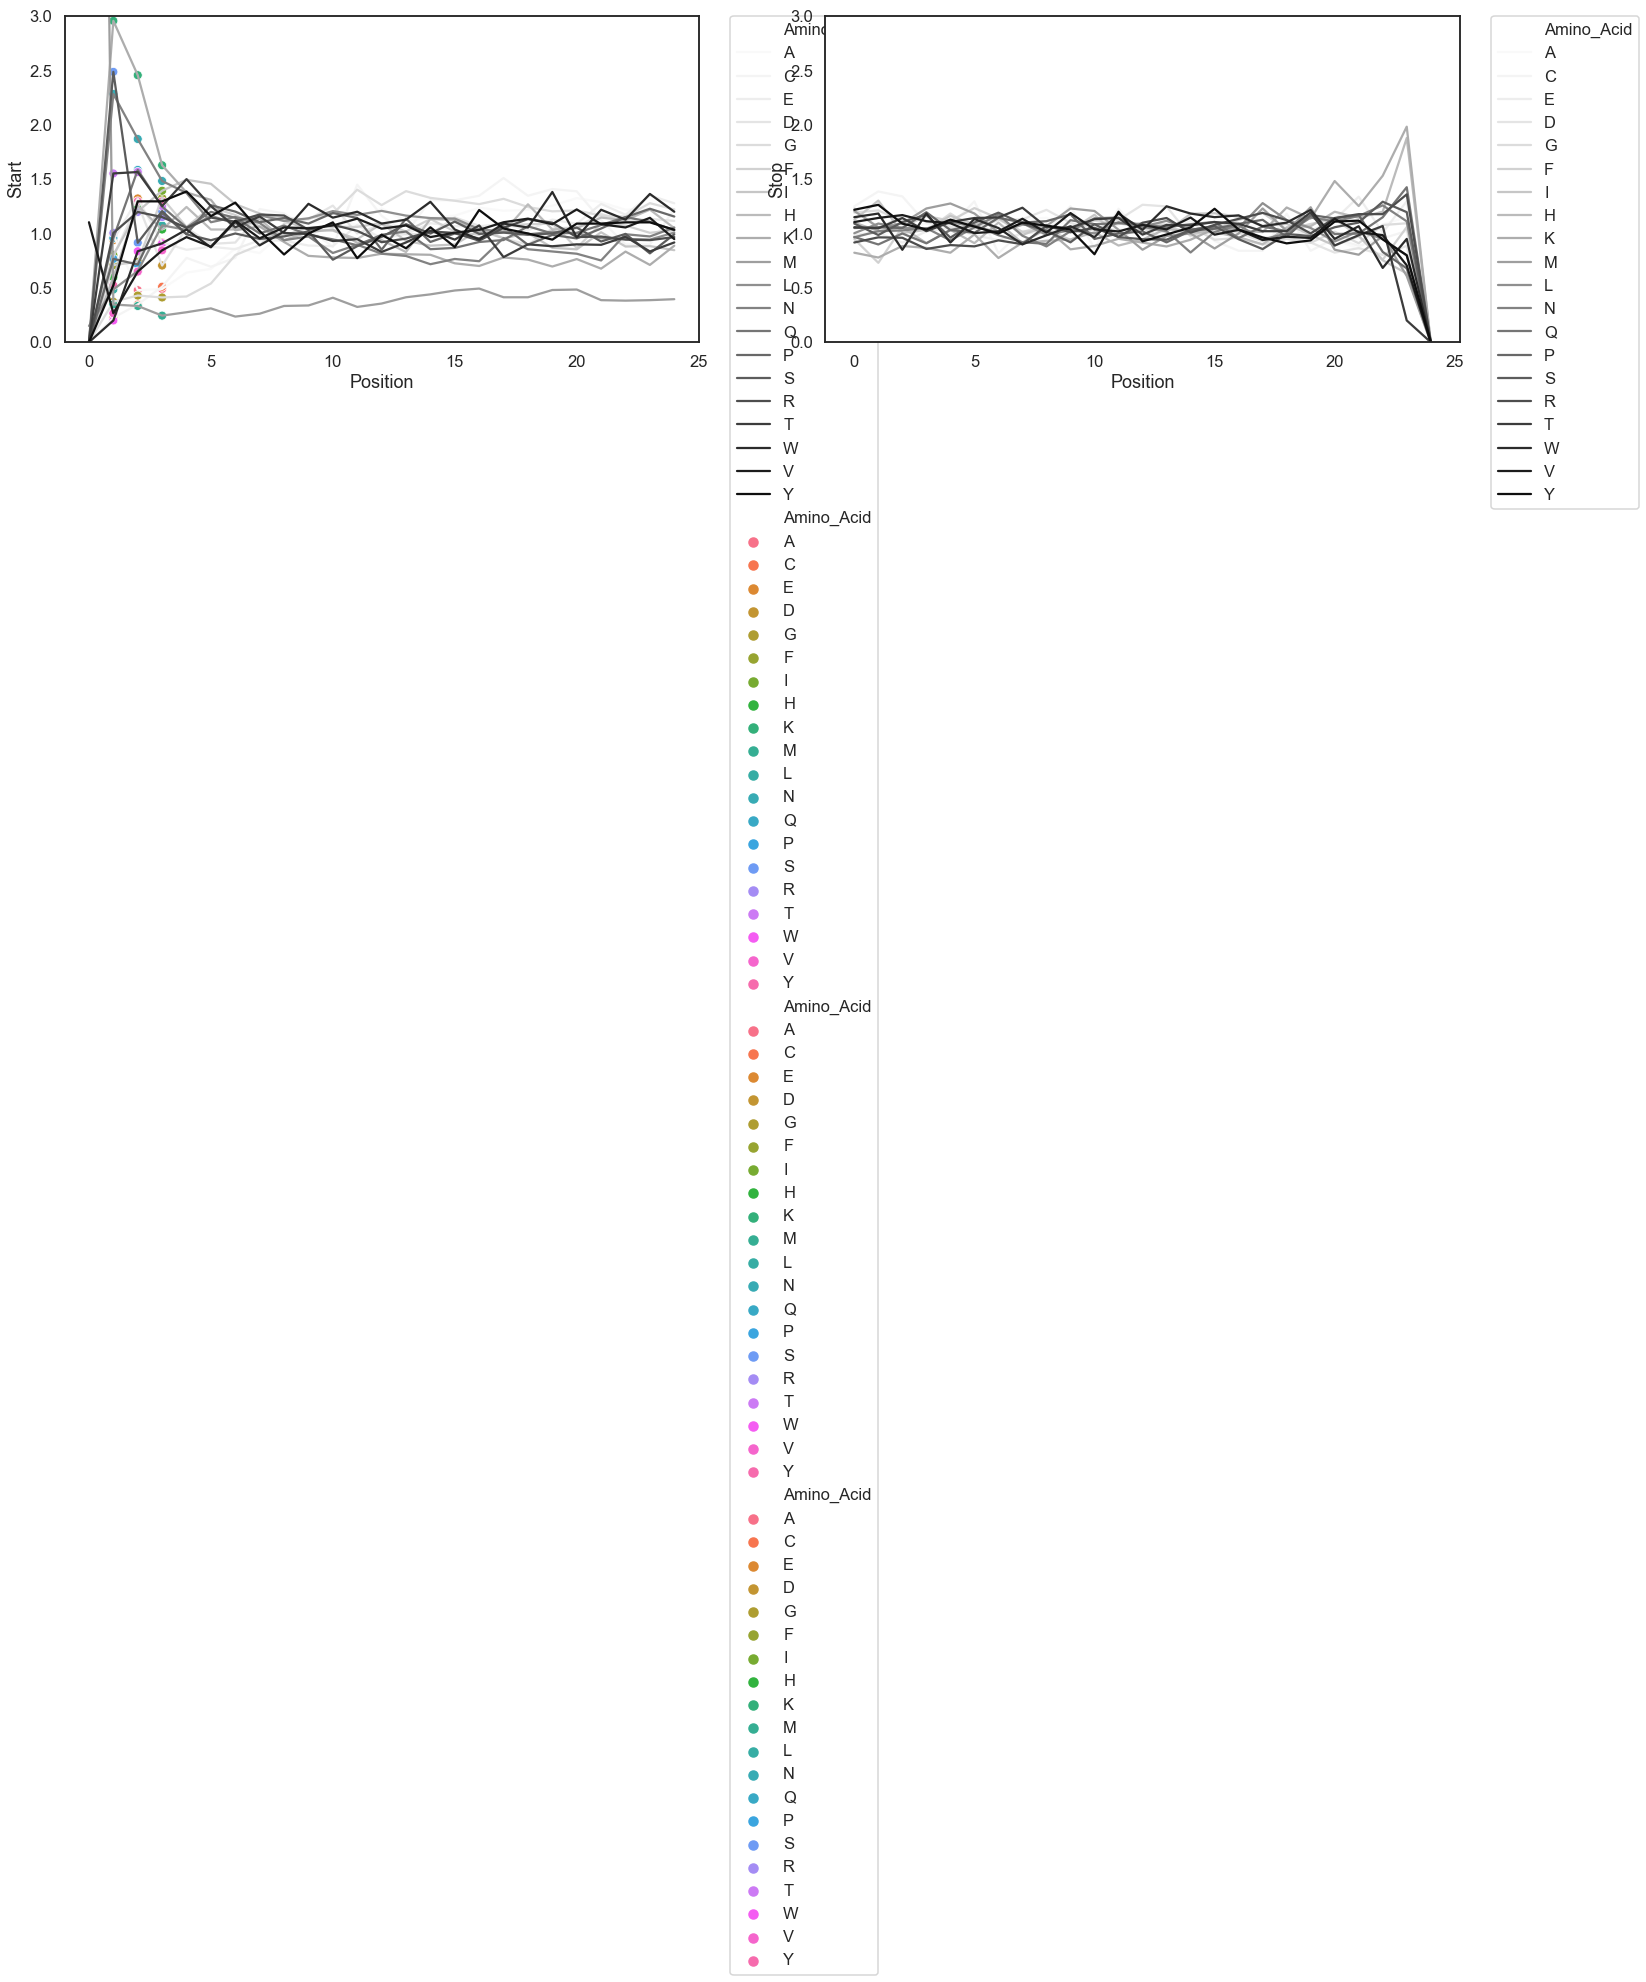

In [5]:
sns.set(style="white") 
sns.set_context("talk")
plt.figure(figsize=(25,6))
plt.subplot(1,2,1)

plot1 = sns.lineplot(x="Position", y="Start" , hue = "Amino_Acid", data=data_df, palette = 'Greys',)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0, 3)


negative = data_df.loc[data_df.Position == 1]
display(negative)

plot1 = sns.scatterplot(x="Position", y="Start", hue = "Amino_Acid", data=negative, color = 'r',)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(-1, 25)

negative = data_df.loc[data_df.Position == 2]
display(negative)

plot1 = sns.scatterplot(x="Position", y="Start", hue = "Amino_Acid", data=negative, color = 'r',)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(-1, 25)


negative = data_df.loc[data_df.Position == 3]
display(negative)

plot1 = sns.scatterplot(x="Position", y="Start", hue = "Amino_Acid", data=negative, color = 'r',)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(-1, 25)


'''negative = data_df.loc[data_df.Amino_Acid == "K"]

plot1 = sns.lineplot(x="Position", y="Start", hue = "Amino_Acid", data=negative, palette = 'Blues',)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

negative = data_df.loc[data_df.Amino_Acid == "S"]

plot1 = sns.lineplot(x="Position", y="Start", hue = "Amino_Acid", data=negative, palette = 'Blues',)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

negative = data_df.loc[data_df.Amino_Acid == "N"]

plot1 = sns.lineplot(x="Position", y="Start", hue = "Amino_Acid", data=negative, palette = 'Blues',)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)'''

plt.subplot(1,2,2)
plot2 = sns.lineplot(x="Position", y="Stop", hue='Amino_Acid', data=data_df, palette = 'Greys',)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0, 3)

path_gff_analysis =  paths_in['path_gff_analysis']

path_save = path_gff_analysis + 'codon_composition2.pdf'
plt.savefig(path_save, dpi=400, bbox_inches="tight")

plt.show()



In [6]:
print 'hello'


hello
